# Traffic Sign Recognition

The Dataset: 

# Initialization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools
import datetime

# Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model

# metrics
import tensorflow_addons as tfa 

# cv2
import cv2

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

#XAI
import shap
import keras.backend as K


In [2]:
print (tf.__version__)

2.7.0


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# General Parameters

In [4]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [5]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [6]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, color='blue', label='Training acc')
        plt.plot(epochs, val_acc, color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

# plot a test image

def get_input_img(sign_class, img_height, img_width, index = 0, dataset='Test'):
    def reshape_img(img):
        img = cv2.resize(img, (img_height,img_width))
        return np.expand_dims(img, axis=0)

    if dataset == 'Train':
        file_path = base_dir + '/Train/' + str(sign_class) + '/'
        file_name = os.listdir(file_path)[index]
        img = cv2.imread(file_path + file_name)
    
    if dataset == 'Test':
        meta = pd.read_csv('./dataset/GTSRB/Test.csv')
        file = meta[meta['ClassId'] == sign_class]['Path'].values[index]
        img = cv2.imread(base_dir + '/' + file)        

    plt.figure(figsize=(3,3))
    plt.imshow(img)
    return reshape_img(img)
        

def plot_feature_maps(model, img):
    successive_outputs = [layer.output for layer in model.layers[1:]]
    inputs = model.inputs
    outputs = successive_outputs
    filters = Model(inputs=inputs, outputs=outputs)
    feature_maps = filters.predict(img)
    layer_names = [layer.name for layer in model.layers]
    for layer_name, feature_map in zip(layer_names, feature_maps):
        print(feature_map.shape)
        if len(feature_map.shape) == 4:
            # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x

            #Display the grid
            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# plot kernel weights

def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_filters (model):
    for layer in model.layers:
        if 'conv' in layer.name:
            weights, bias= layer.get_weights()
            #print(layer.name, filters.shape)
            
            #normalize filter values between  0 and 1 for visualization
            f_min, f_max = weights.min(), weights.max()
            filters = (weights - f_min) / (f_max - f_min)  
            print(filters.shape[3])
            filter_cnt=1
            
            #plotting all the filters
            for i in range(filters.shape[3]):
                #get the filters
                filt=filters[:,:,:, i]
                #plotting each of the channel, color image RGB channels
                for j in range(filters.shape[0]):
                    ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(filt[:, j])
                    filter_cnt+=1
            plt.show()  

In [7]:
#tf.compat.v1.disable_eager_execution()

## MLOps

Weights an Biases init

In [8]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [9]:
#Generic dataset parameters
img_width, img_height = 48, 48
batch_size = 256
cat_num = get_num_classes(train_dir)

# Dataset exploration and preprocessing

## Simple Keras based data augmentation

NOTE:
- We opt not to use zoom as it will distort the sign shapes
- We also opt not to horizontal and vertical flips and signs have directional information which would be lost

Found 27447 images belonging to 43 classes.


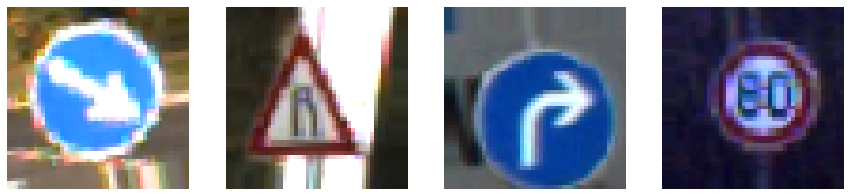

In [10]:
# dry running the generator and fine-tunning the parameters

train_datagen = ImageDataGenerator(validation_split=0.3, 
    # we will not use vertical/horizontal flip as signs have directional information that is revelant
    # adding a img rotation of up to 20º
    rotation_range=10,
    # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
    width_shift_range=.1, 
    height_shift_range=.1,
    fill_mode='nearest',
    # adding a brightness range of 1 to 1.2 - after visual inspection
    brightness_range=[1,1.2]
    # zoom
    #zoom_range=0.2,
    #zca_whitening
    )
        
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    class_mode='categorical'
    )

# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')


In [11]:
# training dataset
# With Keras data augmentation

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
        #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, 
        # we will not use vertical/horizontal flip as signs have directional information that is revelant
        # adding a img rotation of up to 20º
        rotation_range=10,
        # adding a img translation of up to 20% of the image size - We found some issues with the fill mode = 'nearest'
        width_shift_range=.1, 
        height_shift_range=.1,
        fill_mode='nearest',
        # adding a brightness range of 1 to 1.2 - after visual inspection
        brightness_range=[1,1.2],
        # zoom
        #zoom_range=0.2,
        rescale=1./255)
        
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[1,1.2]
        )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False
        )
    
    return test_generator

In [12]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [13]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


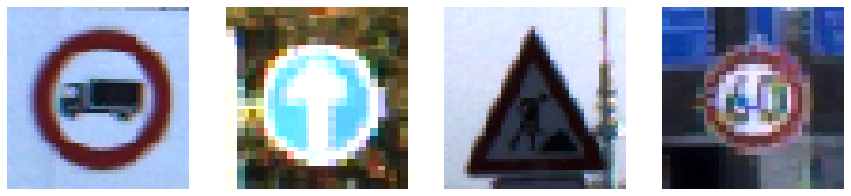

In [14]:
# plotting a sample from the training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(test_generator)[0]

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [15]:
print('Batches train=%d, test=%d' % (len(train_generator), len(test_generator)))

Batches train=108, test=50


In [16]:
# getting some test images for XAI
X, y = next(test_generator)
to_explain = X[20:30]


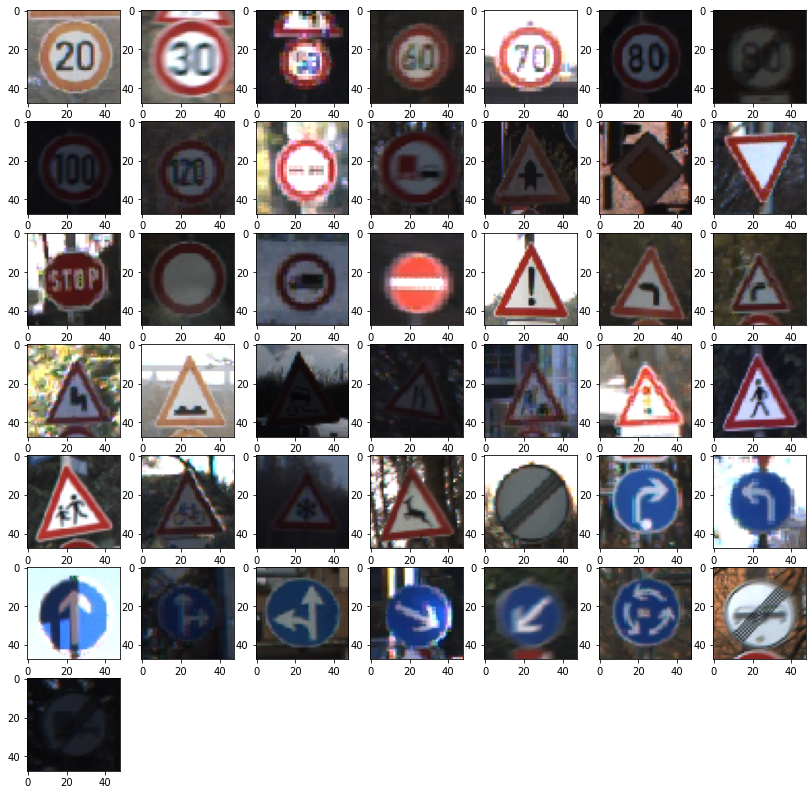

In [17]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [18]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

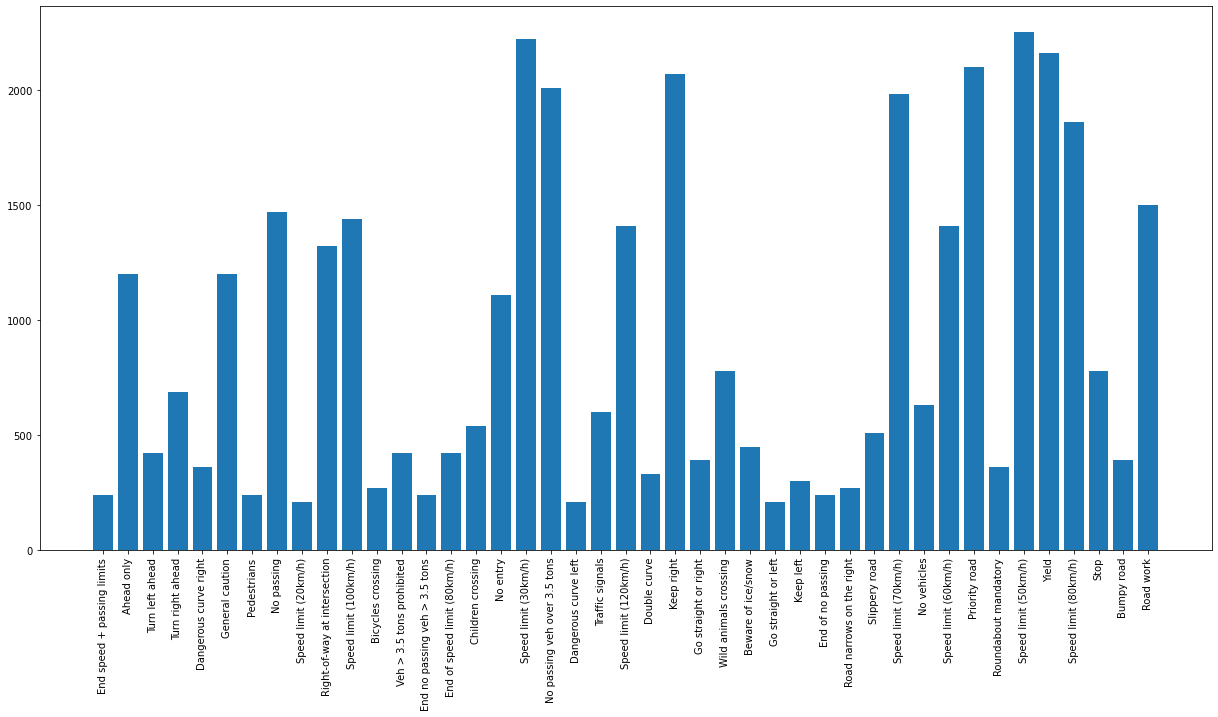

In [19]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [20]:
# Calculating the weights to compensate for the class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 4.342192691029901,
 1: 0.4107479572595852,
 2: 0.45366192294342245,
 3: 0.6908033826638478,
 4: 0.43421926910299,
 5: 0.4221576227390181,
 6: 1.1690518783542039,
 7: 1.4473975636766334,
 8: 2.1710963455149503,
 9: 0.8214959145191704,
 10: 0.7598837209302326,
 11: 4.342192691029901,
 12: 0.40527131782945736,
 13: 2.5329457364341086,
 14: 2.763213530655391,
 15: 2.3381037567084078,
 16: 1.7879616963064295,
 17: 3.3772609819121446,
 18: 0.607906976744186,
 19: 1.5197674418604652,
 20: 3.7994186046511627,
 21: 1.6886304909560723,
 22: 3.3772609819121446,
 23: 0.6467095497278575,
 24: 2.026356589147287,
 25: 1.1690518783542039,
 26: 3.7994186046511627,
 27: 1.321536905965622,
 28: 2.1710963455149503,
 29: 0.7598837209302326,
 30: 2.3381037567084078,
 31: 4.342192691029901,
 32: 0.44051230198854063,
 33: 3.0395348837209304,
 34: 0.4605355884425652,
 35: 2.5329457364341086,
 36: 3.7994186046511627,
 37: 3.7994186046511627,
 38: 0.49024756189047264,
 39: 2.1710963455149503,
 40: 0.63323643

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [21]:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

## Baseline

- No Class weights

### Training And Evaluating The Model

## miniVGGNet


In [22]:
chanDim = -1
miniVGGmodel = Sequential()
# MLP - input layer
miniVGGmodel.add(Conv2D(8, (5, 5), activation = relu, padding="same", input_shape=(img_width, img_height, 3)))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(Conv2D(16, (3, 3), activation = relu, padding="same"))
miniVGGmodel.add(BatchNormalization(axis=chanDim))
miniVGGmodel.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Flatten())
miniVGGmodel.add(Dense(units=128, activation=relu))
miniVGGmodel.add(BatchNormalization())
miniVGGmodel.add(Dropout(0.5))

miniVGGmodel.add(Dense(units=cat_num, activation=softmax))

# Check built model:
miniVGGmodel.summary()

2022-01-27 17:16:37.532753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-27 17:16:37.532855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                             

In [23]:
# adding f1-score
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(num_classes=cat_num, average='weighted' or 'macro' or 'samples')

# adding a tunned Adam optimizer with learning rate = 0.001 as a tunnable HYP
opt = Adam(learning_rate=0.01)

miniVGGmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

In [24]:
# Common attributes:
# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num,
    "class_weights": True
}

mlops_config['steps_per_epoch'] = 100
mlops_config['epochs'] = 300
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'categorical_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['learning_rate'] = 0.001,
mlops_config['restore_best_weights'] = True
mlops_config['metrics'] = ['acc', f1]

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 30
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=mlops_config['restore_best_weights'])

In [26]:
# MLOps init and callback
run_id = 'TS_miniVGG' + str(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
run = wandb.init(name=run_id , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_miniVGGmodel = miniVGGmodel.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    class_weight=class_weights,
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)
The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


2022-01-27 17:16:43.222452: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/300


2022-01-27 17:16:43.705599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 2.9209 - acc: 0.1704 - f1_score: 0.1785

2022-01-27 17:17:07.086006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 28s 225ms/step - loss: 2.9209 - acc: 0.1704 - f1_score: 0.1785 - val_loss: 4.1884 - val_acc: 0.1209 - val_f1_score: 0.0975
Epoch 2/300
100/100 [==============================] - 23s 225ms/step - loss: 1.7358 - acc: 0.4139 - f1_score: 0.4184 - val_loss: 2.2772 - val_acc: 0.3477 - val_f1_score: 0.3444
Epoch 3/300
100/100 [==============================] - 23s 230ms/step - loss: 1.2398 - acc: 0.5541 - f1_score: 0.5572 - val_loss: 1.6368 - val_acc: 0.5102 - val_f1_score: 0.5069
Epoch 4/300
100/100 [==============================] - 23s 235ms/step - loss: 0.9299 - acc: 0.6386 - f1_score: 0.6406 - val_loss: 1.7134 - val_acc: 0.5260 - val_f1_score: 0.5309
Epoch 5/300
100/100 [==============================] - 23s 228ms/step - loss: 0.7416 - acc: 0.7068 - f1_score: 0.7079 - val_loss: 1.0540 - val_acc: 0.6820 - val_f1_score: 0.6801
Epoch 6/300
100/100 [==============================] - 22s 223ms/step - loss: 0.6351 - acc: 0.7517 - f1_score: 0.7525 - va

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


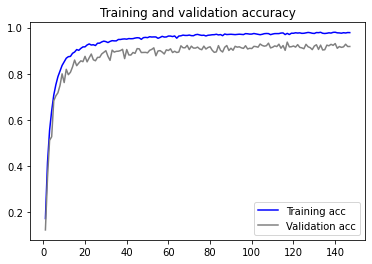

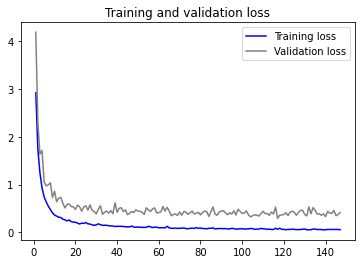

In [27]:
plot_results(history_miniVGGmodel)

2022-01-27 18:10:37.429614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Confusion matrix, without normalization
[[ 47   0   0 ...   0   2   0]
 [  2 694   0 ...   2   0   0]
 [  0   1 646 ...   0   0   3]
 ...
 [  0   0   0 ... 406  24   0]
 [  0   0   0 ...   7 427   2]
 [  0   0   9 ...   0   0 470]]


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/pyplot.py'>

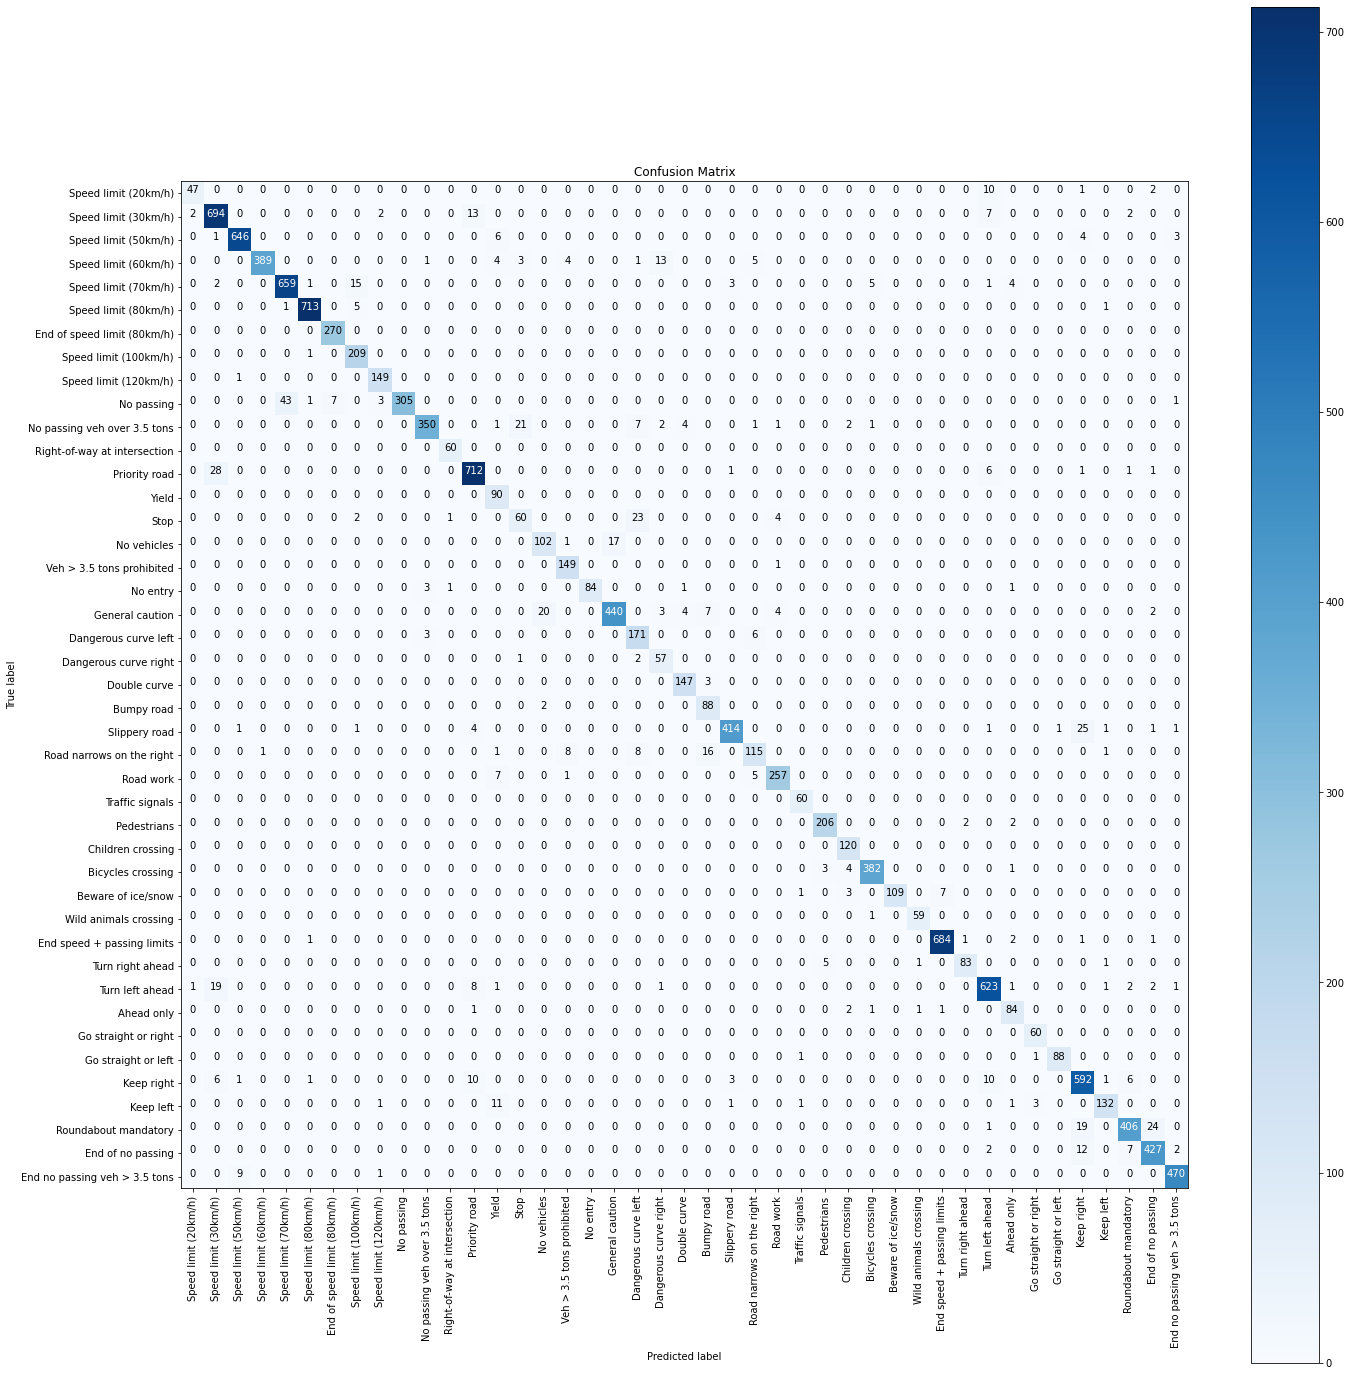

In [28]:
# predictions on Test data

Y_pred = miniVGGmodel.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

In [29]:
from sklearn import metrics
print(metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values())))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.78      0.94      0.85        50
         Speed limit (30km/h)       0.96      0.93      0.94       750
         Speed limit (50km/h)       0.98      0.98      0.98       658
         Speed limit (60km/h)       0.93      1.00      0.96       390
         Speed limit (70km/h)       0.96      0.94      0.95       703
         Speed limit (80km/h)       0.99      0.99      0.99       718
  End of speed limit (80km/h)       1.00      0.97      0.99       277
        Speed limit (100km/h)       1.00      0.90      0.95       232
        Speed limit (120km/h)       0.99      0.96      0.97       156
                   No passing       0.85      1.00      0.92       305
 No passing veh over 3.5 tons       0.90      0.98      0.94       357
 Right-of-way at intersection       1.00      0.97      0.98        62
                Priority road       0.95      0.95      0.95       748
     

In [30]:
#uploading artifacts to MLOps
fig.savefig('./confusion_matrix.png')
report = metrics.classification_report(y_pred, test_generator.classes, target_names=list(classes.values()), output_dict=True)
report = pd.DataFrame(report).T
df_report = wandb.Table(data=report)

artifact = wandb.Artifact(run_id, type='Confusion Matrix', description='Test Results')
artifact.add_file('confusion_matrix.png')
artifact.add(df_report, name='Test F1 Scores')
run.log_artifact(artifact)

Shape before entering the conv layer: (1, 48, 48, 3)


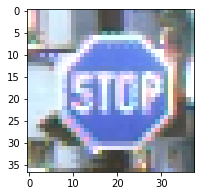

In [31]:
# plotting feature maps
img = get_input_img(14, img_width, img_height, 3, 'Test')
print ('Shape before entering the conv layer:', img.shape)

2022-01-27 18:10:44.523408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(1, 48, 48, 8)
(1, 24, 24, 8)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 24, 24, 16)
(1, 12, 12, 16)
(1, 2304)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 43)


invalid value encountered in true_divide
divide by zero encountered in true_divide


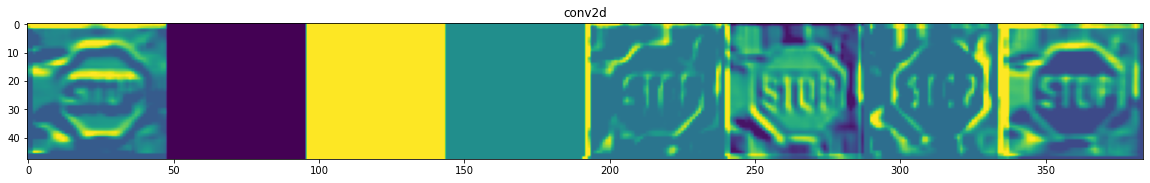

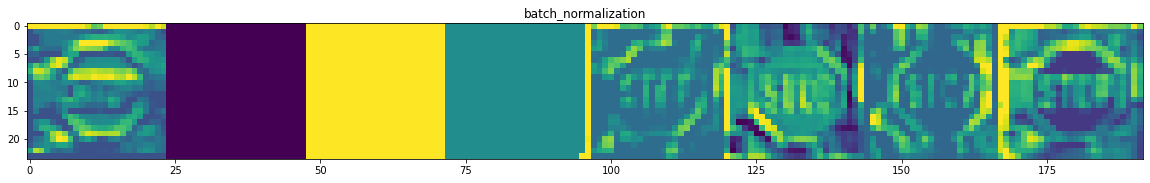

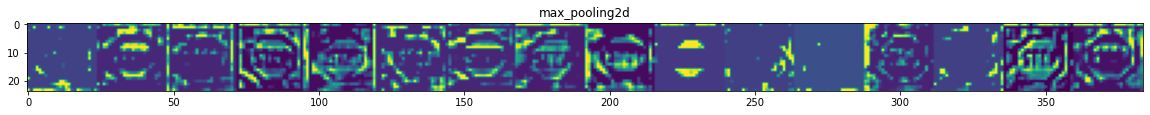

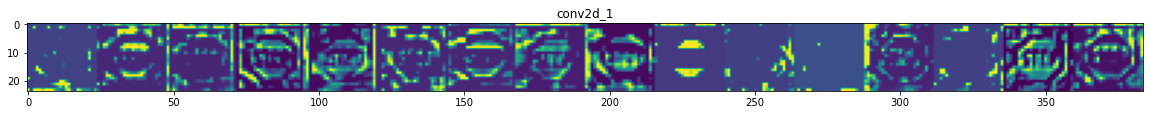

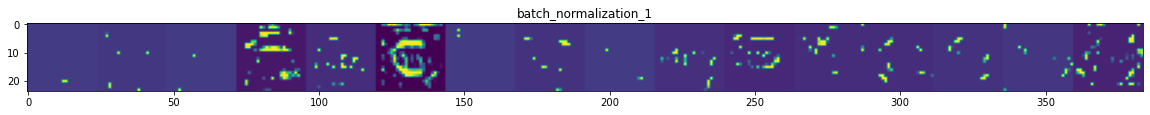

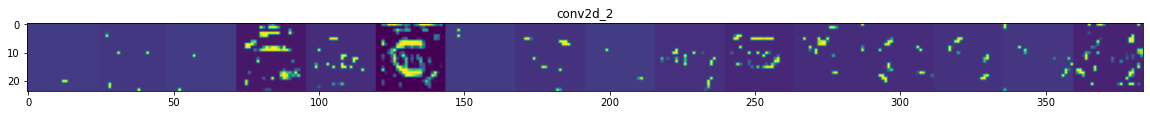

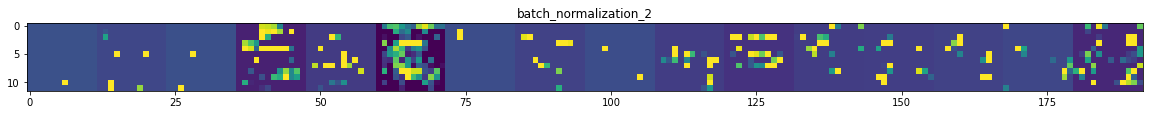

In [32]:
plot_feature_maps(miniVGGmodel, img)

8


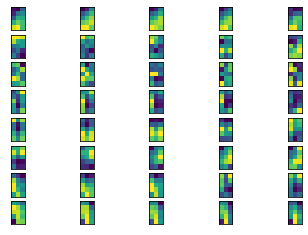

16


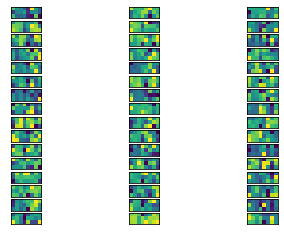

16


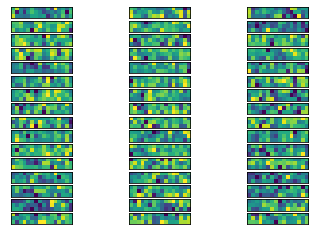

In [33]:
show_filters(miniVGGmodel)

In [34]:
explainer = shap.GradientExplainer(miniVGGmodel, X)
# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values(to_explain)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-01-27 18:10:47.565827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 18:10:48.468172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 18:10:48.983791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 18:10:49.518327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 18:10:50.106611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-27 18:

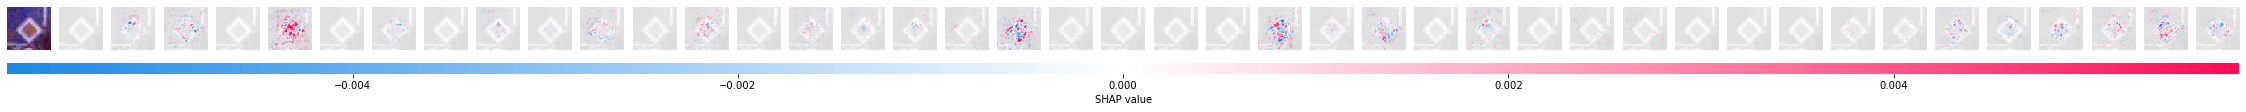

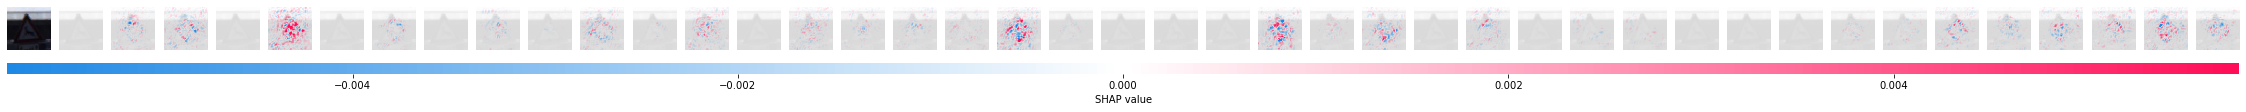

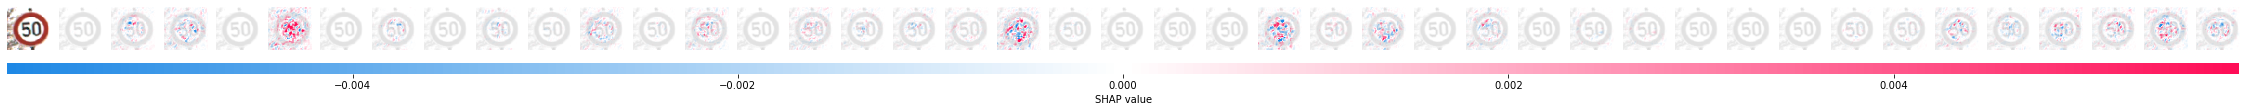

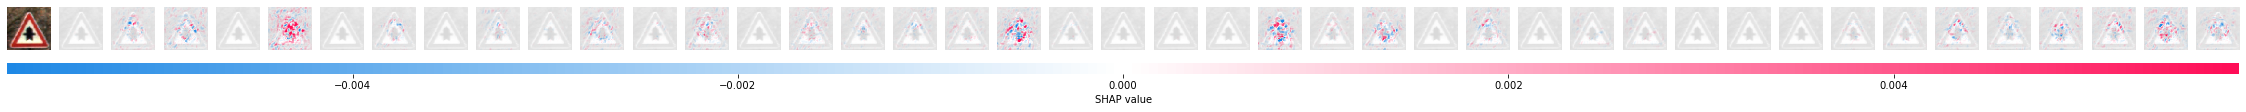

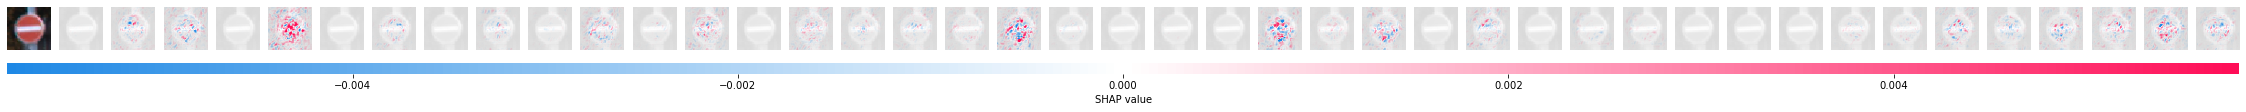

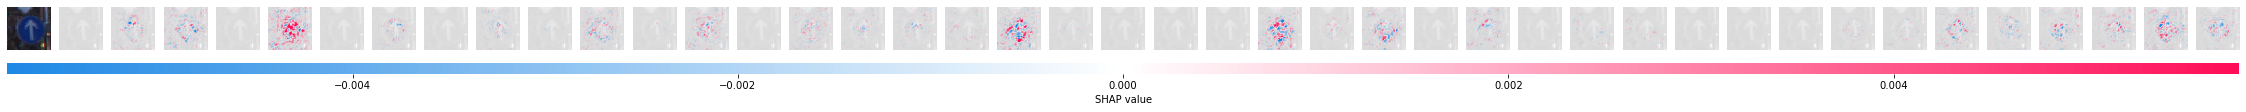

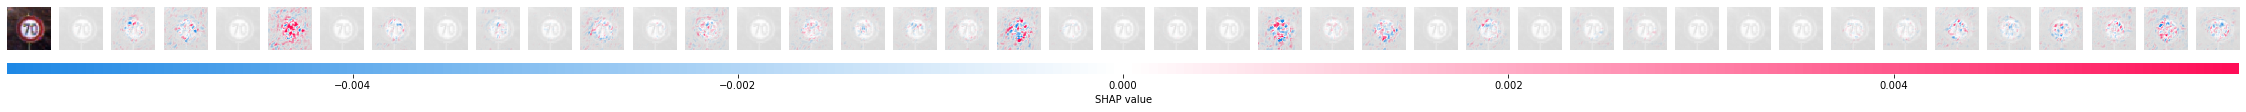

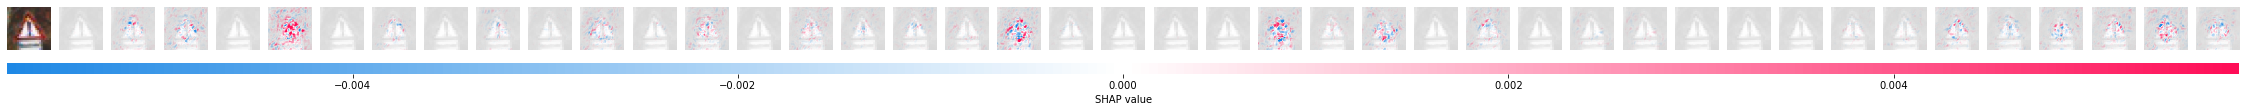

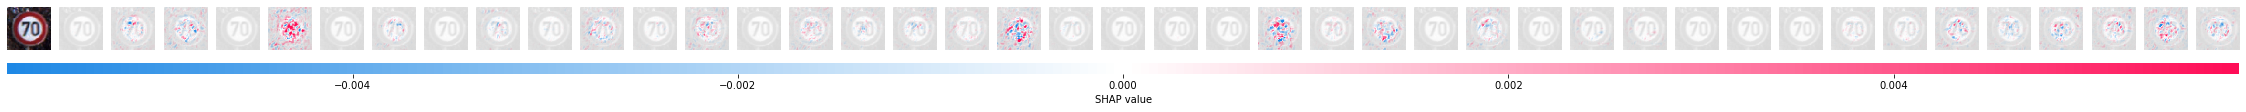

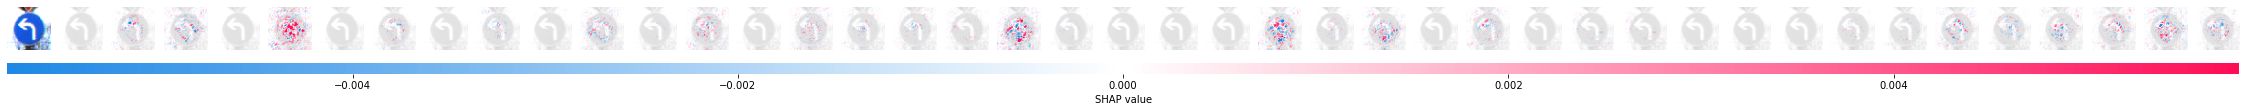

[None, None, None, None, None, None, None, None, None, None]

In [35]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
[shap.image_plot([shap_values[i][0] for i in range(42)], img, width=40) for img in to_explain]

In [36]:
run.finish()

acc,▁▄▆▇▇▇▇▇████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▆▇▇▇▇▇████████████████████████████████
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
val_acc,▁▃▆▆▇▇▇▇███▇█▇██████████████████████████
val_f1_score,▁▃▆▆▇▇▇▇███▇████████████████████████████
val_loss,█▆▄▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁
acc,0.97838
best_epoch,116
best_val_loss,0.29223


In [37]:
wandb.finish()

# 